In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

import torch
from zisnmf import ZISNMF,add_V_components_to_anndata,plot_rank_genes_groups

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)



/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
adata = sc.read_h5ad('/home/oem/Workspace/SUREMO_Ex/blood/NeurIPS2021/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')
adata.X = adata.layers['counts'].copy()

genes=adata.var_names[adata.var['feature_types']=='GEX']
adata=adata[:,genes].copy()

In [3]:
adata.obs['n_features'] = np.sum(adata.X>0, axis=1)
nonzero_features = np.sum(adata.X>0, axis=0)>0

adata = adata[:,nonzero_features]

features =[x for x in adata.var_names if (not x.startswith('RPS')) and (not x.startswith('RPL')) and (not x.startswith('MT-'))]
adata = adata[:,features]
adata.shape

(69249, 13323)

In [4]:
cluster_name = 'cell_type'

n_cells = adata.shape[0]
n_genes = adata.shape[1]
n_clusters = adata.obs[cluster_name].unique().shape[0]
n_extra_states = 100


In [5]:
annot_groups = adata.obs[cluster_name].values
annot_labels = encoder.fit_transform(annot_groups.reshape(-1,1))
annot_labels = np.argmax(annot_labels, axis=1)

L = torch.zeros((n_cells, n_clusters))
L[np.arange(n_cells), annot_labels] = 1.0

In [6]:
num_epochs = 30
learning_rate = 0.001
alpha = 0.2
batch_size=1024


model = ZISNMF(n_cells, n_genes, n_clusters, n_extra_states, random_seed=42, delta=0.0, device=torch.device('cuda'))
M, V, _, _ = model.fit_transform(adata.X.toarray(), L, num_epochs=num_epochs, learning_rate=learning_rate, alpha=alpha, batch_size=batch_size)


Training: 100%|██████████| 30/30 [02:44<00:00,  5.49s/epoch, loss=4.41e+7]


In [7]:
V_df = pd.DataFrame(V, index=encoder.categories_[0].tolist(), columns=adata.var_names)
V_df.head()

,AL627309.5,LINC01409,LINC01128,NOC2L,KLHL17,ISG15,C1orf159,SDF4,B3GALT6,UBE2J2,...,CMC4,MTCP1,BRCC3,VBP1,CLIC2,TMLHE-AS1,TMLHE,VAMP7,AL592183.1,AC240274.1
B1 B,0.003158,0.006077,0.009196,0.015529,0.006153,0.035125,0.011943,0.029927,0.006519,0.014083,...,0.000822,0.006978,0.025539,0.015374,0.000610,0.021967,0.046681,0.006627,0.054265,0.002697
CD14+ Mono,0.011733,0.014968,0.005669,0.018373,0.002177,0.033482,0.017052,0.018000,0.004326,0.031633,...,0.000647,0.004340,0.019840,0.010991,0.002830,0.027573,0.056789,0.013767,0.023983,0.002946
CD16+ Mono,0.007287,0.013378,0.009041,0.024491,0.003104,0.110795,0.016906,0.027305,0.005605,0.032689,...,0.000345,0.002301,0.025617,0.010322,0.006513,0.050238,0.064338,0.012409,0.021630,0.003177
CD4+ T activated,0.000290,0.017312,0.018631,0.024837,0.002484,0.050897,0.018981,0.033386,0.008940,0.030541,...,0.002872,0.006295,0.023989,0.023073,0.003272,0.017997,0.025570,0.011609,0.043218,0.000171
CD4+ T naive,0.000000,0.018347,0.012794,0.019619,0.004035,0.051381,0.018020,0.030185,0.009333,0.032062,...,0.008959,0.006723,0.021083,0.022731,0.000764,0.021610,0.029514,0.009705,0.023780,0.001009


In [8]:
V_adata = sc.AnnData(V_df.values, obs=pd.DataFrame(encoder.categories_[0], columns=[cluster_name]))
V_adata.var_names=adata.var_names
V_adata.obs['cluster'] = V_adata.obs[cluster_name].astype('category')

/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
known_marker_genes_dict = {'CD14+ Mono':['CD14'],
                      'CD16+ Mono':['FCGR3A'],
                      'pDC':['TCF4'],
                      'cDC2':[],
                      'Naive CD20+ B':['IGHD'],
                      'B1 B':['MS4A1'],
                      'Transitional B':['MME'],
                      'Plasma cell':['MZB1'],
                      'CD4+ T naive':['CD4'],
                      'CD4+ T activated':['IL7R'],
                      'CD8+ T':['CD8A'],
                      'CD8+ T naive':[],
                      'NK':['FCER1G'],
                      'ILC':['ID2'],
                      'HSC':['MECOM'],
                      'G/M prog':['MPO'],
                      'ID2-hi myeloid prog':['KLF4'],
                      'Lymph prog':['IGLL1'],
                      'MK/E prog':['ITGA2B'],
                      'Proerythroblast':['SYNGR1'],
                      'Erythroblast':['MKI67'],
                      'Normoblast':['SLC4A1']}

known_marker_genes = list()
for k in known_marker_genes_dict.keys():
    known_marker_genes.extend(known_marker_genes_dict[k])


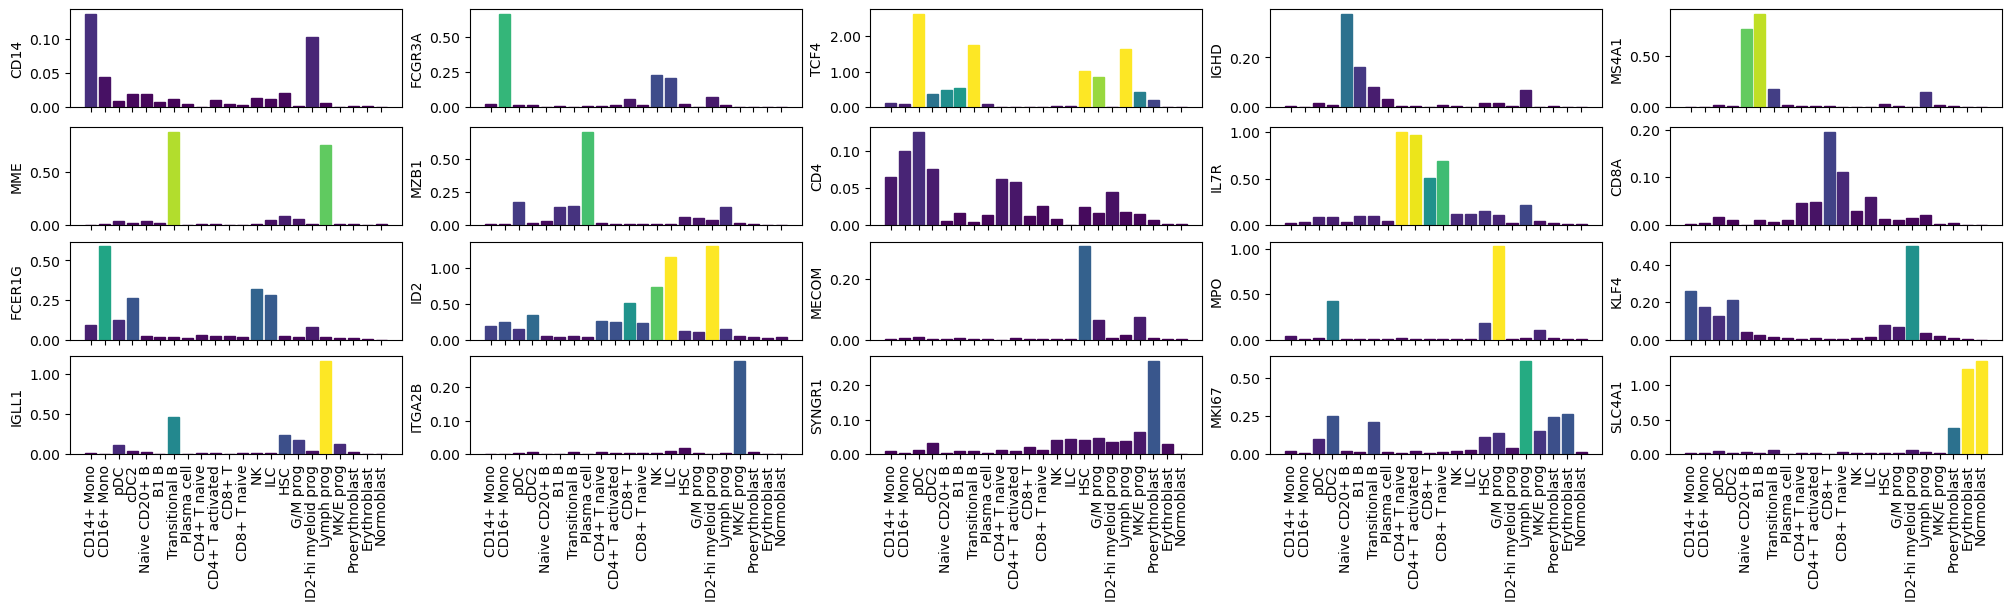

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

df = V_df.loc[list(known_marker_genes_dict.keys()),:][known_marker_genes]


# Number of columns and subplots configuration
num_plots = df.shape[1]
num_columns = 5
num_rows = (num_plots + num_columns - 1) // num_columns  # Calculate number of rows needed

# Create subplots with constrained_layout for better alignment
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 1.5), sharex=True, constrained_layout=True)
axes = axes.flatten()  # Flatten the 2D array of axes

# Determine the global y limits
global_y_min = df.min().min()
global_y_max = df.max().max()

# Function to format y-axis labels with two decimal places
def format_func(value, tick_number):
    return f"{value:.2f}"

# Plot each column in a separate subplot
for idx, col in enumerate(df.columns):
    ax = axes[idx]
    values = df[col]
    bars = ax.bar(df.index, values, color=sns.color_palette("viridis", len(values)))
    ax.set_ylabel(col)
    #ax.set_ylim(global_y_min, global_y_max)  # Set consistent y limits
    
    # Format y-axis labels
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))
    
    # Color bars according to their values
    for bar, value in zip(bars, values):
        bar.set_color(sns.color_palette("viridis", as_cmap=True)(value))

# Set x-axis labels for the bottom subplots only
for ax in axes[-num_columns:]:
    ax.set_xticks(range(len(df.index)))
    ax.set_xticklabels(df.index, rotation=90)


# Remove any unused subplots
for idx in range(num_plots, len(axes)):
    fig.delaxes(axes[idx])


# Adjust layout with constrained_layout
plt.show()